# HW_4:Симуляция распространения болезни. Работа с NetworkX.

### Цель: смоделировать распространение инфекции по международной сети аэропортов, увидеть, как заражение аэропортов-хабов приводит к взрывному росту заболеваний и создать свой локальный Plague Inc.,

Описание/Пошаговая инструкция выполнения домашнего задания: \
Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.

Часть 1. Пишем симуляцию. \
Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт. \
В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).

Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения? \
Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?\
Настало время поработать с NetworkX. 
3.1.По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
3.2.Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
3.3.Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
3.4.Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?
https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

# Часть 1. Пишем симуляцию

In [1]:
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

import networkx as nx
from scipy.stats import spearmanr
import random

In [2]:
data = pd.read_csv('2008.csv')
data.head().T

,0,1,2,3,4
Year,2008,2008,2008,2008,2008
Month,1,1,1,1,1
DayofMonth,3,3,3,3,3
DayOfWeek,4,4,4,4,4
DepTime,2003.0,754.0,628.0,926.0,1829.0
CRSDepTime,1955,735,620,930,1755
ArrTime,2211.0,1002.0,804.0,1054.0,1959.0
CRSArrTime,2225,1000,750,1100,1925
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,335,3231,448,1746,3920


In [3]:
data.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [4]:
### Оставим колонки, содержащие время отправления и прибытия, а также пункты отправления и назначения.

In [5]:
essens_data = data[['Year', 'Month', 'DayofMonth', 'DepTime', 'ArrTime', 'Origin', 'Dest']]
essens_data.head(3)

,Year,Month,DayofMonth,DepTime,ArrTime,Origin,Dest
0,2008,1,3,2003.0,2211.0,IAD,TPA
1,2008,1,3,754.0,1002.0,IAD,TPA
2,2008,1,3,628.0,804.0,IND,BWI


In [6]:
essens_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Year        int64  
 1   Month       int64  
 2   DayofMonth  int64  
 3   DepTime     float64
 4   ArrTime     float64
 5   Origin      object 
 6   Dest        object 
dtypes: float64(2), int64(3), object(2)
memory usage: 374.4+ MB


### Преобразуем данные о времени прибытия и отправления в формат времени

In [7]:
essens_data = essens_data.rename(columns={'DayofMonth': 'Day'})

In [8]:
essens_data.dropna(axis=0, subset=['DepTime', 'ArrTime'], inplace=True)
essens_data.isna().sum()

Year       0
Month      0
Day        0
DepTime    0
ArrTime    0
Origin     0
Dest       0
dtype: int64

In [9]:
essens_data[['DepTime', 'ArrTime']] = essens_data[['DepTime', 'ArrTime']].astype('int16')
essens_data.head()

,Year,Month,Day,DepTime,ArrTime,Origin,Dest
0,2008,1,3,2003,2211,IAD,TPA
1,2008,1,3,754,1002,IAD,TPA
2,2008,1,3,628,804,IND,BWI
3,2008,1,3,926,1054,IND,BWI
4,2008,1,3,1829,1959,IND,BWI


In [10]:
# Функция конвертации
def convert_time(data, time_column_name):
    
    def to_military(x:int):
        y = str(x)
        while len(y) < 4:
            y = ''.join(['0', y])
        return  y
    
    def hours(x: str):
        return x[:2]
    def minutes(x: str):
        return x[2:]
    
    data['Temp'] = data[time_column_name].apply(lambda x: to_military(x))
    data['Hour'] = data['Temp'].apply(lambda x: hours(x))
    data['Minute'] = data['Temp'].apply(lambda x: minutes(x))
    data[time_column_name] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour','Minute']])
    data.drop(['Temp', 'Hour', 'Minute'], axis=1, inplace=True)

In [11]:
convert_time(essens_data, 'DepTime')
convert_time(essens_data, 'ArrTime')

In [12]:
essens_data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

In [13]:
essens_data.head(3)

,DepTime,ArrTime,Origin,Dest
0,2008-01-03 20:03:00,2008-01-03 22:11:00,IAD,TPA
1,2008-01-03 07:54:00,2008-01-03 10:02:00,IAD,TPA
2,2008-01-03 06:28:00,2008-01-03 08:04:00,IND,BWI


In [14]:
# Определение необходимых столбцов и указание удобных наименований
essens_data = essens_data[['Origin', 'Dest', 'DepTime', 'ArrTime']]
essens_data.columns = ['source_air', 'dest_air', 'start_time', 'end_time']

essens_data.head()

,source_air,dest_air,start_time,end_time
0,IAD,TPA,2008-01-03 20:03:00,2008-01-03 22:11:00
1,IAD,TPA,2008-01-03 07:54:00,2008-01-03 10:02:00
2,IND,BWI,2008-01-03 06:28:00,2008-01-03 08:04:00
3,IND,BWI,2008-01-03 09:26:00,2008-01-03 10:54:00
4,IND,BWI,2008-01-03 18:29:00,2008-01-03 19:59:00


In [19]:
#essens_data.to_csv('data_new.csv')

In [15]:
essens_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6858079 entries, 0 to 7009727
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   source_air  object        
 1   dest_air    object        
 2   start_time  datetime64[ns]
 3   end_time    datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 261.6+ MB


## 1.1.Симуляция распространения инфекции

In [16]:
# Функция имитации одного прохода распространения инфекции
# преобразуем row.end_time в число с помощью метода timestamp() и добавим к нему случайное число. 

In [28]:
def spread_infection(infec_airport, infec_prob):
    # Определение начала времени заражения
    start_time = essens_data[essens_data.source_air == infec_airport].start_time.min()
    
    # Определение общего списка зараженных аэропортов
    infec_airports = {start_time: infec_airport}
    
    # Имитация распространения инфекции и заражения городов
    for row in essens_data.itertuples():
        if (row.source_air in infec_airports.values()) and (row.dest_air not in infec_airports.values()):
            if np.random.binomial(1, infec_prob) == 1:
                infec_airports[row.end_time.timestamp() + np.random.random()] = row.dest_air
    
    return infec_airports

In [29]:
# Проверим вызов функции
infec_airport = 'IAD'
infec_prob = 0.5
result = spread_infection(infec_airport, infec_prob)

In [30]:
# result - словарь, поэтому выводим так:
for key in list(result.keys())[:5]:
    print(key, ":", result[key])

2008-01-01 00:05:00 : IAD
1199398260.2271001 : TPA
1199394960.2168689 : ALB
1199385300.5276535 : BDL
1199344800.1686816 : BHM


# Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

In [35]:
# Результаты имитаций заражения
simulated_infec = []

# Имитация заражения городов с разной инфекционностью
for prob in [0.01, 0.1, 1.0]:
    # Результат одной имитации
    infec_airports = []
    
    # Имитация заражения городов с несколькими проходами
    for iteration in range(5):
        random_airport = np.random.choice(essens_data.source_air.unique())
        infec_airports.append(spread_infection(random_airport, infec_prob))
    
    # Конвертирование данных имитации заражения в датасет
    result_df = pd.DataFrame(infec_airports).stack().unstack(0)
    result_df.index = result_df.index.map(pd.Timestamp)  # Просто используем pd.Timestamp для конвертации индексов
    
    # Формирование списка результатов имитаций
    simulated_infec.append(result_df)

# Вывод одного из датасетов
simulated_infec[0].head()


,0,1,2,3,4
2008-07-08 07:50:00.000000000,LMT,NaN,NaN,LMT,NaN
1970-01-01 00:00:01.215717000,SFO,NaN,NaN,NaN,NaN
1970-01-01 00:00:01.215702720,CIC,NaN,NaN,NaN,NaN
1970-01-01 00:00:01.215727980,OTH,NaN,NaN,NaN,NaN
1970-01-01 00:00:01.215709800,RDM,NaN,NaN,NaN,NaN


In [36]:
# Количество аэропортов
count_airports = len(essens_data.dest_air.unique())

# Датасеты с количеством зараженных городов
count_infec = []

# Формирование для каждой вероятности датасета с
# количеством зараженных городов в интервале 12 часов
for i in range(len(simulated_infec)):
    group_times = simulated_infec[i].resample('12H').count()
    count_infec.append(group_times.apply(lambda x: np.around(x.mean(), 0), axis=1))

# Объединение датасетов для разных вероятностей в один общий
count_infec_df = pd.concat(count_infec, keys=[0.01, 0.1, 1.0])
count_infec_df = count_infec_df.unstack(0, fill_value=0)

# Вывод процента зараженных аэропортов для каждых 12 часов симуляции
(count_infec_df.cumsum() / count_airports * 100).astype(int)

,0.01,0.10,1.00
1970-01-01 00:00:00,98,99,99
1970-01-01 12:00:00,98,99,99
1970-01-02 00:00:00,98,99,99
1970-01-02 12:00:00,98,99,99
1970-01-03 00:00:00,98,99,99
...,...,...,...
2008-07-06 00:00:00,98,99,99
2008-07-06 12:00:00,98,99,99
2008-07-07 00:00:00,98,99,99
2008-07-07 12:00:00,98,99,99


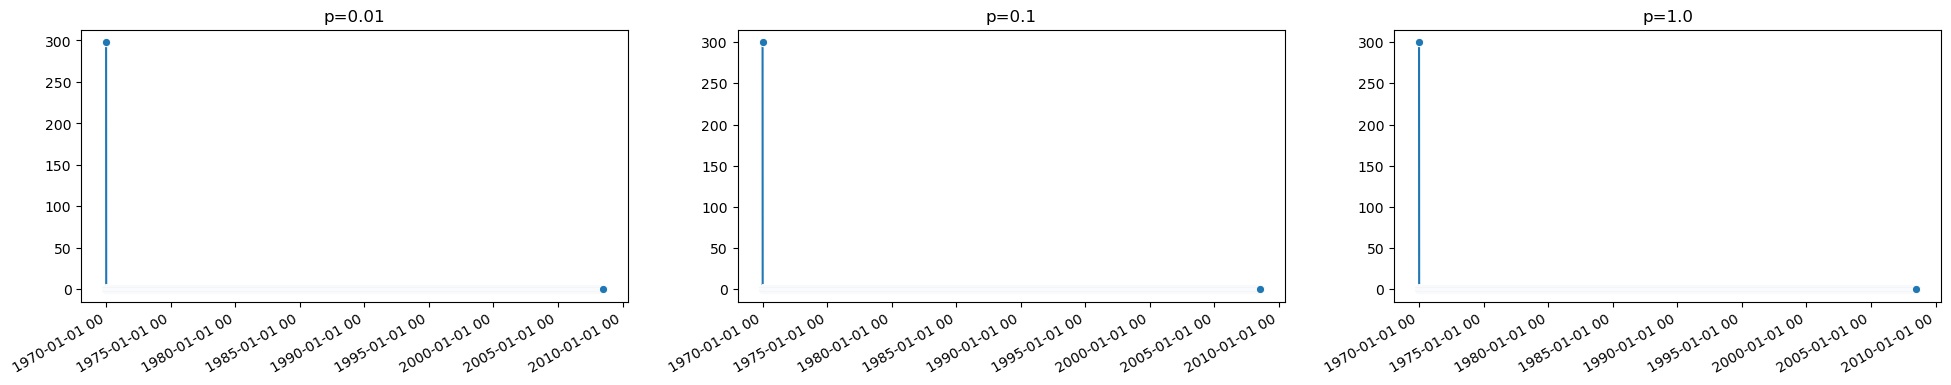

In [42]:
# Определение размера диаграммы
fig, axes = plt.subplots(1, 3, figsize=(24, 4))

# Вывод числа зараженных городов в зависимости от времени для каждой из вероятностей
for ax, column in zip(axes.flatten(), count_infec_df.columns):
    sns.lineplot(x=count_infec_df.index, y=count_infec_df[column],  marker="o", ax=ax)
    
    # Определение формата вывода дат оси абсцисс и заголовков диаграмм
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
    ax.set(xlabel='', ylabel='', title='p='+str(column))

# Поворот меток оси абсцисс на 30 градусов
plt.gcf().autofmt_xdate()

# Вывод диаграммы
plt.show()

# Может ли информация о сети помочь предсказать, кто будет заражен?

In [44]:
# Создание датасета маршрутов следования самолетов
routes_data = essens_data[['source_air', 'dest_air']].copy()

# Формирование маршрутов следования самолетов
routes_data['route_ab'] = routes_data.source_air + routes_data.dest_air
routes_data['route_ba'] = routes_data.dest_air + routes_data.source_air

# Определение числа перелетов между аэропортами
for row in routes_data.itertuples():
    routes_data.loc[row.Index, 'count_routes'] = (
        (routes_data.route_ab.values==row.route_ab).sum() + (routes_data.route_ab.values==row.route_ba).sum()
    )

# Определение веса каждого маршрута
routes_data['weight_routes'] = routes_data['count_routes'] / len(routes_data)

# Расстановка столбцов датасета в нужном порядке
routes_data = routes_data[['source_air', 'dest_air', 'route_ab', 
                           'route_ba', 'count_routes', 'weight_routes']]

# Вывод датасета
routes_data.head()

KeyboardInterrupt: 

In [ ]:
# Определение размера диаграммы
plt.figure(figsize=(6, 6))

# Построение графа
graph = nx.from_pandas_edgelist(routes_data, 'source_air', 'dest_air', 'weight_routes')

# Вывод графа
nx.draw(graph, node_size=70, alpha=0.8)

In [ ]:
# Результаты имитаций заражения
simulated_infec = []
    
# Имитация заражения городов с несколькими проходами
for iteration in range(20):
    infec_airports = pd.DataFrame(spread_infection('ABE', 0.5).items(), columns=['time', 'airport'])
    simulated_infec.append(infec_airports)

# Объединение результатов имитации в один общий датасет
simulated_infec_df = pd.concat(simulated_infec)

# Определение времени до заражения каждого аэропорта
start_time = simulated_infec_df[simulated_infec_df.airport=='ABE'].time.min()
simulated_infec_df['time_infec'] = simulated_infec_df.time - start_time

# Расстановка столбцов датасета в нужном порядке
simulated_infec_df = simulated_infec_df[['airport', 'time', 'time_infec']]
    
# Вывод датасета
simulated_infec_df.head()

In [ ]:
# Вывод медианного времени до заражения каждого города
median_metric = simulated_infec_df.groupby('airport')['time_infec'].median().sort_index()
median_metric.head()

In [ ]:
# Вывод коэффициента кластеризации
clustering_metric = pd.Series(nx.clustering(graph)).sort_index()
clustering_metric.head()

In [ ]:
# Вывод степени графа
degree_metric = pd.Series(dict(nx.degree(graph))).sort_index()
degree_metric.head()

In [ ]:
# Вывод центральности графа
centrality_metric = pd.Series(nx.betweenness_centrality(graph)).sort_index()
centrality_metric.head()

In [ ]:
# Расчет ранговой корреляции Спирмена для полученных метрик графа
coef, p_value = spearmanr(median_metric, clustering_metric)
print('Коэффициент Спирмена для Median и Clustering:  coef={:.2f}  p-value={:.2f}'.format(coef, p_value))

coef, p_value = spearmanr(median_metric, degree_metric)
print('Коэффициент Спирмена для Median и Degree:      coef={:.2f}  p-value={:.2f}'.format(coef, p_value))

coef, p_value = spearmanr(median_metric, centrality_metric)
print('Коэффициент Спирмена для Median и Centrality:  coef={:.2f}  p-value={:.2f}'.format(coef, p_value))